# Creating, Evaluating, and Deploying an Uplift Model

## Introduction

In this notebook, we'll demonstrate the data science work flow with an end-to-end example. The scenario is to create, train and evaluate an uplift model that refers to a collection of machine learning techniques that are employed to estimate the incremental effects of a treatment on an individual or a sub-group behavior. 

The summary of the main steps we take in this notebook are as following:

1. Load and process the data
2. Understand the data using exploratory data analysis
3. Train a machine learning model using an Uplift model
4. Save the final machine learning model
5. Load the machine learning model for scoring and making predictions

## Prerequisites
- Have a lakehouse added to this notebook. We will be downloading data from a public blob, and storing that in the lakehouse. 

### What is Uplift Modeling?

Uplift modeling is a set of causal inference techniques that utilize machine learning models to identify the most suitable treatment (from a group of treatments) that leads to the most desirable outcome. This is determined empirically by studying a treatment group (individuals with treatment) and a control group (individuals without treatment). This approach classifies individuals into four main subgroups within a population:

- **Persuadables**: These individuals respond positively only when given the treatment.
- **Sleeping-dogs**: This group shows a strong negative response to the treatment.
- **Lost Causes**: Individuals in this category will never achieve the desired outcome, even with the treatment.
- **Sure Things**: This group will achieve the outcome regardless of whether they receive the treatment or not.


The primary objective of uplift modeling is to identify the **"persuadables"** since targeting them can lead to a more favorable outcome. Conversely, directing efforts towards the **"lost causes"** and **"sure things"** groups would be ineffective, and the **"sleeping dogs"** group could potentially result in negative outcomes. Uplift modeling finds practical applications in various fields such as marketing, healthcare, and social sciences, where it optimizes decision-making and enhances the effectiveness of interventions.

### How does Uplift modeling work?

The main techniques used for uplift modeling include:

- Meta Learner that predicts the difference between an individual's behavior when there is a treatment and when there is not a treatment.

- Uplift Tree which is a tree-based algorithm that takes information about treatment/control group assignment and information about the response directly into decisions about splitting criterion for a node. 

- Neural Network-based Model which usually works with observational data and helps to learn the distribution of a latent variable using deep learning. We use the latent variable to represent the co-founder in the uplift modeling.

### How does Uplift modeling benefit?

- In marketing applications, uplift modeling can help to identify persuadables who can be swayed by the treatment that could be a coupon or an online advertisement.
- In medical treatment, uplift modeling can help in comprehending how a particular treatment can affect distinct groups, allowing for optimized target selection to maximize its impact.


## Dataset

The dataset was created by The Criteo AI Lab and consists of 13M rows, each one representing a user with twelve features, a treatment indicator, and two binary labels that include visit and conversion.

|f0|f1|f2|f3|f4|f5|f6|f7|f8|f9|f10|f11|treatment|conversion|visit|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

- **f0 - f11**: feature values (dense, floating values)
- **treatment**: indicates whether a user was randomly targeted for treatment (i.e., advertising) or not (1 = treatment, 0 = control)
- **conversion**: indicates whether a conversion occurred (i.e., made a purchase) for this user (binary, label)
- **visit**: indicates whether a visit occurred (i.e., visit the online store) for this user (binary, label)

## Citation


- Dataset homepage: https://ailab.criteo.com/criteo-uplift-prediction-dataset/
```
@inproceedings{Diemert2018,
author = {{Diemert Eustache, Betlei Artem} and Renaudin, Christophe and Massih-Reza, Amini},
title={A Large Scale Benchmark for Uplift Modeling},
publisher = {ACM},
booktitle = {Proceedings of the AdKDD and TargetAd Workshop, KDD, London,United Kingdom, August, 20, 2018},
year = {2018}
}
```

## Step 1: Load the Data

**By defining below parameters, we can apply this notebook on different datasets easily.**

In [ ]:
IS_CUSTOM_DATA = False  # if True, dataset has to be uploaded manually by user
DATA_FOLDER = "Files/uplift-modelling"
DATA_FILE = "criteo-research-uplift-v2.1.csv"

FEATURE_COLUMNS = [f"f{i}" for i in range(12)]
TREATMENT_COLUMN = "treatment"
LABEL_COLUMN = "visit"

EXPERIMENT_NAME = "aisample-upliftmodelling"  # mlflow experiment name

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 3, Finished, Available)

#### Import Libraries

Prior to any processing, we need to import required libraries for Spark, SynapseML, and data visualization such as seaborn which is a Python data visualization library to provide a high-level interface for building visuals on dataframes and arrays. You can learn more about Spark, SynapseML and Seaborn [here](https://spark.apache.org/), [here](https://aka.ms/AboutSynapseML), and [here](https://seaborn.pydata.org/) respectively. 

In [ ]:
import os
import gzip

import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

%matplotlib inline

from synapse.ml.featurize import Featurize
from synapse.ml.core.spark import FluentAPI
from synapse.ml.lightgbm import *
from synapse.ml.train import ComputeModelStatistics

import mlflow

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 4, Finished, Available)

#### Download dataset and upload to lakehouse

The following code will download a publicly available version of the the dataset and then store it in a Fabric Lakehouse.

**Please add a lakehouse to the notebook before running it. Failure to do so will result in an error.**

Instructions to add a lakehouse to the notebook can be found [here](https://aka.ms/fabric/addlakehouse).

In [ ]:
if not IS_CUSTOM_DATA:
    # Download demo data files into lakehouse if not exist
    import os, requests

    remote_url = "http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz"
    download_file = "criteo-research-uplift-v2.1.csv.gz"
    download_path = f"/lakehouse/default/{DATA_FOLDER}/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
    os.makedirs(download_path, exist_ok=True)
    if not os.path.exists(f"{download_path}/{DATA_FILE}"):
        r = requests.get(f"{remote_url}", timeout=30)
        with open(f"{download_path}/{download_file}", "wb") as f:
            f.write(r.content)
        with gzip.open(f"{download_path}/{download_file}", "rb") as fin:
            with open(f"{download_path}/{DATA_FILE}", "wb") as fout:
                fout.write(fin.read())
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 5, Finished, Available)

Downloaded demo data files into lakehouse.


We start recording the time it takes to run this notebook.

In [ ]:
# Record the notebook running time
import time

ts = time.time()


StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 6, Finished, Available)

#### Setup the MLflow experiment tracking

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. Further information about how to perform autologging can be found [here](https://aka.ms/fabric-autologging).

In [ ]:
# Setup mlflow experiment
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # disable mlflow autologging

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 7, Finished, Available)

Note that if we want to disable Microsoft Fabric autologging in a notebook session, we can call `mlflow.autolog()` and set `disable=True`.

#### Read data from the lakehouse

We start by reading the data from the lakehouse and then explore the raw data using `display`.

In [ ]:
raw_df = spark.read.csv(f"{DATA_FOLDER}/raw/{DATA_FILE}", header=True, inferSchema=True).cache()

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 8, Finished, Available)

## Step 2: Exploratory Data Analysis

We can explore using the `display` command to view high-level statistics of the dataset.

In [ ]:
display(raw_df.limit(20))

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 9, Finished, Available)

SynapseWidget(Synapse.DataFrame, aec1408e-74fa-433d-a3ab-aa21b776037c)

We look into the percentage of the users that visit, the percentage of users that convert, and the percentage of the visitors that convert.

In [ ]:
raw_df.select(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()


StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 10, Finished, Available)

+------------------------------+--------------------------------+-----------------------------------+
|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+------------------------------+--------------------------------+-----------------------------------+
|          0.046992000911042324|            0.002916680257907384|                0.06206759025709019|
+------------------------------+--------------------------------+-----------------------------------+



The above analysis indicates that 4.7% of all users visited the online store and only 0.29% converted (i.e., made a purchase). As a result, the conversion rate of visitors is 6.2%.

We also examine the overall average treatment effect on visits and conversions, where a treatment of 1 indicates the user offered or exposed to advertising (i.e., discount coupons, gifts, or other privileges), and a treatment of 0 indicates the user is not offered or exposed to any form of advertising.

In [ ]:
raw_df.groupby("treatment").agg(
    F.mean("visit").alias("Percentage of users that visit"),
    F.mean("conversion").alias("Percentage of users that convert"),
    (F.sum("conversion") / F.sum("visit")).alias("Percentage of visitors that convert"),
).show()


StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 11, Finished, Available)

+---------+------------------------------+--------------------------------+-----------------------------------+
|treatment|Percentage of users that visit|Percentage of users that convert|Percentage of visitors that convert|
+---------+------------------------------+--------------------------------+-----------------------------------+
|        1|          0.048543360048743316|            0.003089461067412...|                0.06364332968115058|
|        0|           0.03820095691954503|            0.001937588015281...|                0.05072092878097497|
+---------+------------------------------+--------------------------------+-----------------------------------+



The analysis suggests that 4.9% of users from the treatment group (that have received the treatment (i.e., advertising)) visited the online store, while only 3.8% of users from the control group (that did not receive the treatment (i.e., not offered or exposed to advertising)) did the same. Additionally, 0.31% of all users from the treatment group converted (i.e., made a purchase), while only 0.19% of users from the control group did so. As a result, the conversion rate (i.e., made a purchase) for visitors that were users of treatment group is 6.36%, compared to only 5.07% for users of the control group. This means that the treatment can potentially improve the visit rate by about 1% and the conversion rate of visitors by about 1.3%, which is a significant improvement.

## Step 3: Define the Model for Training

#### Prepare training and test datasets

We fit a Featurize transformer to the `raw_df` DataFrame to extract features from the specified input columns and output them to a new column named `features`.

The resulting DataFrame is stored in a new DataFrame named `df`.

In [ ]:
transformer = Featurize().setOutputCol("features").setInputCols(FEATURE_COLUMNS).fit(raw_df)
df = transformer.transform(raw_df)

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 12, Finished, Available)

In [ ]:
# Split the DataFrame into training and test sets with a 80/20 ratio and a seed of 42
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Print the size of the training and test datasets
print("Size of train dataset: %d" % train_df.count())
print("Size of test dataset: %d" % test_df.count())

# Group the training dataset by the treatment column and count the number of occurrences of each value
train_df.groupby(TREATMENT_COLUMN).count().show()

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 13, Finished, Available)

Size of train dataset: 11182965
Size of test dataset: 2796627
+---------+-------+
|treatment|  count|
+---------+-------+
|        1|9505415|
|        0|1677550|
+---------+-------+



#### Prepare treatment and control datasets

Once we have created the training and test datasets, we also need to form the treatment and control datasets in order to train machine learning models to measure the uplift.

In [ ]:
# Extract treatment and control DataFrames
treatment_train_df = train_df.where(f"{TREATMENT_COLUMN} > 0")
control_train_df = train_df.where(f"{TREATMENT_COLUMN} = 0")

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 14, Finished, Available)

Now that we have prepared our data we will continue with training a model using LightGBM.


#### Uplift Modeling: T-Learner with LightGBM

Meta learners are a set of algorithms that are built on top of machine learning algorithms like LightGBM, Xgboost, etc. to help estimate conditional average treatment effect (CATE).
T-learner is a meta-learner that uses multiple machine learning models to overcome the problem of discarding the treatment entirely by forcing the learner to first split on it. Instead of using a single model, T-learner uses one model per treatment variable, therefore, two models are developed and hence the name T-learner.

In [ ]:
mlflow.autolog(exclusive=False)

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 15, Finished, Available)

2023/08/04 03:05:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2023/08/04 03:05:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [ ]:
classifier = (
    LightGBMClassifier()
    .setFeaturesCol("features")  # Set the column name for features
    .setNumLeaves(10)  # Set the number of leaves in each decision tree
    .setNumIterations(100)  # Set the number of boosting iterations
    .setObjective("binary")  # Set the objective function for binary classification
    .setLabelCol(LABEL_COLUMN)  # Set the column name for the label
)

# Start a new MLflow run with the name "uplift"
active_run = mlflow.start_run(run_name="uplift")

# Start a new nested MLflow run with the name "treatment"
with mlflow.start_run(run_name="treatment", nested=True) as treatment_run:
    treatment_run_id = treatment_run.info.run_id  # Get the ID of the treatment run
    treatment_model = classifier.fit(treatment_train_df)  # Fit the classifier on the treatment training data

# Start a new nested MLflow run with the name "control"
with mlflow.start_run(run_name="control", nested=True) as control_run:
    control_run_id = control_run.info.run_id  # Get the ID of the control run
    control_model = classifier.fit(control_train_df)  # Fit the classifier on the control training data



StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 16, Finished, Available)

2023/08/04 03:06:12 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('features', VectorUDT(), True)]. Model signature is not logged.
2023/08/04 03:06:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpg3v6y9lb/model, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to DEBUG to see the full traceback.
2023/08/04 03:06:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/08/04 03:07:44 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpai91ab6e/model, flavor: spark), fall back to return ['pyspark==3.3.1']. Set logging level to DEBUG to see the full traceback.


#### Predict using the test dataset

We transform the test dataset `test_df` using the `treatment_model` and `control_model` defined above, and calculate the predicted uplift. Note that the predicted uplift is the difference between the predicted treatment outcome and the predicted control outcome, and the larger the predicted uplift difference, the more effective the treatment (i.e., advertising) has been on an individual or a sub-group.


In [ ]:
getPred = F.udf(lambda v: float(v[1]), FloatType())

# The resulting DataFrame is cached for easier access
test_pred_df = (
    test_df.mlTransform(treatment_model)
    .withColumn("treatment_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .mlTransform(control_model)
    .withColumn("control_pred", getPred("probability"))
    .drop("rawPrediction", "probability", "prediction")
    .withColumn("pred_uplift", F.col("treatment_pred") - F.col("control_pred"))
    .select(TREATMENT_COLUMN, LABEL_COLUMN, "treatment_pred", "control_pred", "pred_uplift")
    .cache()
)

# Display the first 20 rows of the resulting DataFrame
display(test_pred_df.limit(20))

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 17, Finished, Available)

SynapseWidget(Synapse.DataFrame, f0583bc6-dd96-407e-81e5-e5531a923672)

#### Perform Model Evaluation

Since actual uplift cannot be observed for each individual, we measure the uplift over a group of individuals. We will use an Uplift Curve that plots the real cumulative uplift across the population.

![criteo_uplift_curve.jpeg](https://mmlspark.blob.core.windows.net/graphics/notebooks/criteo_uplift_curve.jpeg)

The x-axis represents the ratio of population that have been selected for the treatment, with 0 and 1 suggesting no treatment group (no one is offered or exposed to the treatment) and full treatment group (everyone is offered or exposed to the treatment), respectively. The y-axis shows the uplift measure. The objective is to determine the size of the treatment group (the percentage of the population that would be offered or exposed to the treatment (i.e., advertising)) in order to optimize the target selection to maximize its impact.

There are several steps involved in creating the plot that will be explained below. 

First, we rank the test DataFrame order by the predict uplift which is the difference between the predicted treatment outcome and the predicted control outcome.

In [ ]:
# Compute the percentage rank of the predicted uplift values in descending order and display the top 20 rows
test_ranked_df = test_pred_df.withColumn("percent_rank", F.percent_rank().over(Window.orderBy(F.desc("pred_uplift"))))

display(test_ranked_df.limit(20))

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 18, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9897f0a5-644d-4cef-9fdb-7a6ad1625ee7)

Second, we calculate the cumulative percentage of visits in each of the treatment and control groups.

In [ ]:
# Calculate the number of control and treatment samples
C = test_ranked_df.where(f"{TREATMENT_COLUMN} == 0").count()
T = test_ranked_df.where(f"{TREATMENT_COLUMN} != 0").count()

# Add columns to the DataFrame to calculate the control and treatment cumulative sum
test_ranked_df = (
    test_ranked_df.withColumn(
        "control_label",
        F.when(F.col(TREATMENT_COLUMN) == 0, F.col(LABEL_COLUMN)).otherwise(0),
    )
    .withColumn(
        "treatment_label",
        F.when(F.col(TREATMENT_COLUMN) != 0, F.col(LABEL_COLUMN)).otherwise(0),
    )
    .withColumn(
        "control_cumsum",
        F.sum("control_label").over(Window.orderBy("percent_rank")) / C,
    )
    .withColumn(
        "treatment_cumsum",
        F.sum("treatment_label").over(Window.orderBy("percent_rank")) / T,
    )
)

# Display the first 20 rows of the dataframe
display(test_ranked_df.limit(20))

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 19, Finished, Available)

SynapseWidget(Synapse.DataFrame, 04ae56f4-494b-4076-bffe-fd7ddcf8ada0)

Finally, we calculate the group's uplift at each percentage as the difference between cumulative percentage of visits between the treatment and control groups.

In [ ]:
test_ranked_df = test_ranked_df.withColumn("group_uplift", F.col("treatment_cumsum") - F.col("control_cumsum")).cache()
display(test_ranked_df.limit(20))

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 20, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9c45dccf-9e99-40ae-bf45-7d3b0e638a5d)

We can plot the uplift curve for the test dataset prediction. Note that we need to convert the pyspark DataFrame to pandas DataFrame before plotting.

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 21, Finished, Available)

/tmp/ipykernel_9949/3726734023.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which="major")


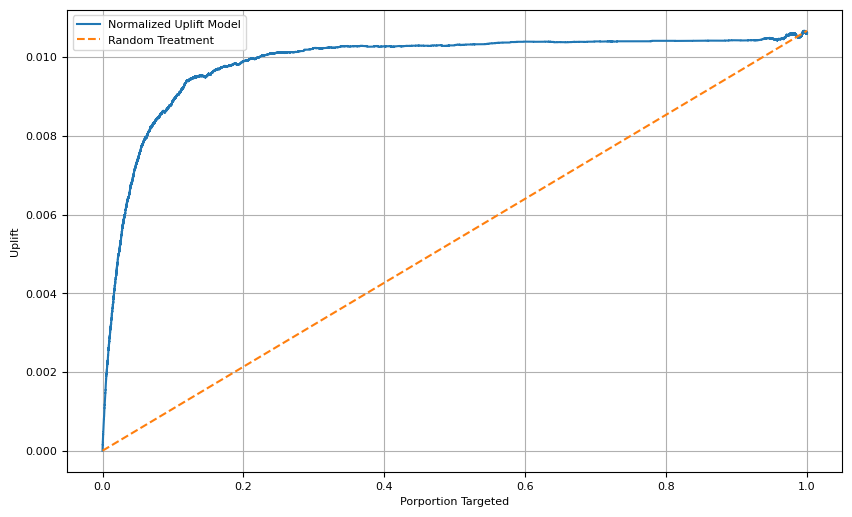

In [ ]:
def uplift_plot(uplift_df):
    """
    Plot the uplift curve
    """
    gain_x = uplift_df.percent_rank
    gain_y = uplift_df.group_uplift
    # Plot the data
    fig = plt.figure(figsize=(10, 6))
    mpl.rcParams["font.size"] = 8

    ax = plt.plot(gain_x, gain_y, color="#2077B4", label="Normalized Uplift Model")

    plt.plot(
        [0, gain_x.max()],
        [0, gain_y.max()],
        "--",
        color="tab:orange",
        label="Random Treatment",
    )
    plt.legend()
    plt.xlabel("Porportion Targeted")
    plt.ylabel("Uplift")
    plt.grid(b=True, which="major")

    return fig, ax


test_ranked_pd_df = test_ranked_df.select(["pred_uplift", "percent_rank", "group_uplift"]).toPandas()
fig, ax = uplift_plot(test_ranked_pd_df)

mlflow.log_figure(fig, "UpliftCurve.png")


From the above analysis and the uplift curve, we can realize that the top 20% population ranked by the prediction would have a drastic gain if they were given the treatment. This indicates that the top 20% population represents the **persuadables** group. Therefore, we can set the cutoff score for the desired size of treatment group at 20% to identify the target selection customers for optimum impact.

In [ ]:
cutoff_percentage = 0.2
cutoff_score = test_ranked_pd_df.iloc[int(len(test_ranked_pd_df) * cutoff_percentage)][
    "pred_uplift"
]

print("Uplift score higher than {:.4f} are Persuadables.".format(cutoff_score))
mlflow.log_metrics(
    {"cutoff_score": cutoff_score, "cutoff_percentage": cutoff_percentage}
)

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 22, Finished, Available)

Uplift score higher than 0.0038 are Persuadables.


## Step 4: Register the final ML Model

We demonstrate how to generate and log an experiment and save the best trained model for later use in the workspace.

In [ ]:
# Register the model
treatment_model_uri = "runs:/{}/model".format(treatment_run_id)
mlflow.register_model(treatment_model_uri, f"{EXPERIMENT_NAME}-treatmentmodel")

control_model_uri = "runs:/{}/model".format(control_run_id)
mlflow.register_model(control_model_uri, f"{EXPERIMENT_NAME}-controlmodel")

mlflow.end_run()

StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 23, Finished, Available)

Successfully registered model 'aisample-upliftmodelling-treatmentmodel'.
2023/08/04 03:08:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-upliftmodelling-treatmentmodel, version 3
Created version '3' of model 'aisample-upliftmodelling-treatmentmodel'.
Successfully registered model 'aisample-upliftmodelling-controlmodel'.
2023/08/04 03:08:56 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: aisample-upliftmodelling-controlmodel, version 3
Created version '3' of model 'aisample-upliftmodelling-controlmodel'.



<img style="float: left;" src="https://synapseaisolutionsa.blob.core.windows.net/public/Uplift-experiment.png"  width="75%" height="30%">


## Step 5: Save Prediction Results
Microsoft Fabric offers a scalable function called PREDICT that supports batch scoring in any compute engine and enables customers to operationalize machine learning models. Users can create batch predictions straight from a notebook or the item page for a particular model. Learn more [here](https://aka.ms/fabric-predict) about PREDICT and how to utilize it in Microsoft Fabric.

In [ ]:
# Load the model back
loaded_treatmentmodel = mlflow.spark.load_model(treatment_model_uri, dfs_tmpdir="Files/spark")
loaded_controlmodel = mlflow.spark.load_model(control_model_uri, dfs_tmpdir="Files/spark")

# Make predictions
batch_predictions_treatment = loaded_treatmentmodel.transform(test_df)
batch_predictions_control = loaded_controlmodel.transform(test_df)
batch_predictions_treatment.show(5)


StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 24, Finished, Available)

2023/08/04 03:08:59 INFO mlflow.spark: 'runs:/fb371d3f-9738-4616-a842-c815ee3253ab/model' resolved as 'sds://lake.trident.com/d2a85142-94be-4d6a-b988-13da340ac6b3/a3ed4027-b7ad-4e61-ae21-481ecdb58075/fb371d3f-9738-4616-a842-c815ee3253ab/artifacts/model'
2023/08/04 03:08:59 INFO mlflow.spark: File 'sds://lake.trident.com/d2a85142-94be-4d6a-b988-13da340ac6b3/a3ed4027-b7ad-4e61-ae21-481ecdb58075/fb371d3f-9738-4616-a842-c815ee3253ab/artifacts/model/sparkml' not found on DFS. Will attempt to upload the file.
2023/08/04 03:09:00 INFO mlflow.spark: Copied SparkML model to Files/spark/f71fd704-8740-4d09-96f9-37cbda875c66
2023/08/04 03:09:02 INFO mlflow.spark: 'runs:/2dc203a2-f6de-4217-87fd-fbd2a2f7f89a/model' resolved as 'sds://lake.trident.com/d2a85142-94be-4d6a-b988-13da340ac6b3/a3ed4027-b7ad-4e61-ae21-481ecdb58075/2dc203a2-f6de-4217-87fd-fbd2a2f7f89a/artifacts/model'
2023/08/04 03:09:03 INFO mlflow.spark: File 'sds://lake.trident.com/d2a85142-94be-4d6a-b988-13da340ac6b3/a3ed4027-b7ad-4e61-a

+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------+--------------------+---------+----------+-----+--------+--------------------+--------------------+--------------------+----------+
|                f0|                f1|               f2|               f3|                f4|                f5|                 f6|                f7|               f8|                f9|              f10|                 f11|treatment|conversion|visit|exposure|            features|       rawPrediction|         probability|prediction|
+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------+------------------+-----------------+------------------+-----------------+--------------------+---------+----------+-----+--------+--------------------+--------------------+----------------

In [ ]:
# Save the predictions into the lakehouse
batch_predictions_treatment.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions_treatment"
)
batch_predictions_control.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions_control"
)


StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 25, Finished, Available)

In [ ]:
print(f"Full run cost {int(time.time() - ts)} seconds.")


StatementMeta(, d1896701-7cf5-4a6d-86ac-123d32475b40, 26, Finished, Available)

Full run cost 398 seconds.
